In [1]:
import time
import os

import torch
import torch.nn as nn
import torchvision.transforms as transforms

from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

# This is for the progress bar.
from tqdm.auto import tqdm

from PIL import Image
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import ImageFilter

In [2]:
'''
SRM滤波得到图像噪声流
'''
def beforeProcess(path):
 
    img = cv2.imread(path, 1)
    img = cv2.resize(img, (128, 128))
 
    kernal = np.array([[[0,0,0,0,0],[0,-1/4,2/4,-1/4,0],[0,2/4,-4/4,2/4,0],[0,-1/4,2/4,-1/4,0],[0,0,0,0,0]],
                    [[-1/12,2/12,-2/12,2/12,-1/12],[2/12,-6/12,8/12,-6/12,2/12],[-2/12,8/12,-12/12,8/12,-2/12],[2/12,-6/12,8/12,-6/12,2/12],[-1/12,2/12,-2/12,2/12,-1/12]],
                        [[0,0,0,0,0],[0,0,0,0,0],[0,1/2,-2/2,1/2,0],[0,0,0,0,0],[0,0,0,0,0]]])
 
 
    dst_r = (cv2.filter2D(img[:,:,0], -1, kernal[0,:,:]) + cv2.filter2D(img[:,:,1], -1, kernal[0,:,:]) + cv2.filter2D(img[:,:,2], -1, kernal[0,:,:]))/3
    dst_g = (cv2.filter2D(img[:,:,0], -1, kernal[1,:,:]) + cv2.filter2D(img[:,:,1], -1, kernal[1,:,:]) + cv2.filter2D(img[:,:,2], -1, kernal[1,:,:]))/3
    dst_b = (cv2.filter2D(img[:,:,0], -1, kernal[2,:,:]) + cv2.filter2D(img[:,:,1], -1, kernal[2,:,:]) + cv2.filter2D(img[:,:,2], -1, kernal[2,:,:]))/3
    dst = cv2.merge([dst_r, dst_g, dst_b])
    
    '''
    前面dst的数据类型为Double，与cuda上float的数据类型不匹配
    '''
    dst = dst.astype(np.float32)
    
#     print(dst.shape)
#     titles = ['srcImg','convImg']
#     imgs = [img, dst]
 
#     # 画图进行展示
#     for i in range(2):
#         plt.subplot(1,2,i+1)
#         plt.imshow(imgs[i])
#         plt.title(titles[i])
#     plt.show()
    
    return dst

'''
训练集处理
'''
class MyTrainDataset(Dataset):
    
    def __init__(self, input_path):
        self.input_path = input_path
        self.input_class = os.listdir(input_path)
        print(self.input_class)
        self.input_au_root = os.path.join(self.input_path, self.input_class[0])
        self.input_tp_root = os.path.join(self.input_path, self.input_class[1])
        self.input_au = os.listdir(self.input_au_root)
        self.input_tp = os.listdir(self.input_tp_root)
        self.input_files = self.input_au + self.input_tp

        self.input_files.remove('Thumbs.db')
        self.input_files.remove('Thumbs.db')
#         for i, name in enumerate(self.input_files):
#             if name=='Thumbs.db':
#                 print(i)
#                 print(True)

                
        random.shuffle(self.input_files)
        
        self.transforms = transforms.Compose([
            transforms.ToTensor(),
        ])
        self.transforms_o = transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.ToTensor(),
        ])
        
    def __len__(self):
        return len(self.input_files)
    
    def __getitem__(self, index):
        if self.input_files[index][:2] == 'Au':
            input_img_path = os.path.join(self.input_au_root, self.input_files[index])
            label = 0
        else:
            input_img_path = os.path.join(self.input_tp_root, self.input_files[index])
            label = 1
        
        input_img = Image.open(input_img_path).convert('RGB')
        noise = beforeProcess(input_img_path)
        input = self.transforms(noise)
        origin = self.transforms_o(input_img)
        
        '''
        验证是否得到噪声信息
        '''
#         print(input_img_path)
#         plt.imshow(noise)
#         plt.show()

        return input, origin, label

'''
验证集处理
'''
class MyValidDataset(Dataset):
    
    def __init__(self, input_path):
        self.input_path = input_path
        self.input_class = os.listdir(input_path)
        print(self.input_class)
        self.input_au_root = os.path.join(self.input_path, self.input_class[4])
        self.input_tp_root = os.path.join(self.input_path, self.input_class[1])
        self.input_au = os.listdir(self.input_au_root)
        self.input_tp = os.listdir(self.input_tp_root)
        self.input_files = self.input_au + self.input_tp
        random.shuffle(self.input_files)
        
        self.transforms = transforms.Compose([
            transforms.ToTensor(),
        ])
        self.transforms_o = transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.ToTensor(),
        ])
        
    def __len__(self):
        return len(self.input_files)
    
    def __getitem__(self, index):
        if self.input_files[index][:2] == 'Au':
            input_img_path = os.path.join(self.input_au_root, self.input_files[index])
            label = 0
        else:
            input_img_path = os.path.join(self.input_tp_root, self.input_files[index])
            label = 1
        
        input_img = Image.open(input_img_path).convert('RGB')
        noise = beforeProcess(input_img_path)
        input = self.transforms(noise)
        origin = self.transforms_o(input_img)
        
        '''
        验证是否得到噪声信息
        '''
#         print(input_img_path)
#         plt.imshow(noise)
#         plt.show()

        return input, origin, label
    
    
        
        

In [3]:
'''
超参数
'''
batch_size = 16
n_epochs = 250
patience = 250
learning_rate = 0.0001

In [4]:
'''
数据集路径
'''
train_path = '../input/casia-dataset/CASIA2/'
valid_path = '../input/casia-dataset/CASIA1/'

train_set = MyTrainDataset(train_path)
valid_set = MyValidDataset(valid_path)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, pin_memory=True)


['Au', 'Tp']
['check.py', 'Sp', '01FixSize.py', 'extraction.py', 'Au']


In [5]:
'''
残差卷积网络（引入了BN层以优化随机梯度下降的方法）
'''
class Residual_Network(nn.Module):
    def __init__(self):
        super(Residual_Network, self).__init__()

        self.cnn_layer1 = nn.Sequential(
            nn.Conv2d(6, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
        )

        self.cnn_layer2 = nn.Sequential(
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
        )

        self.cnn_layer3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, 2, 1),
            nn.BatchNorm2d(128),
        )

        self.cnn_layer4 = nn.Sequential(
            nn.Conv2d(128, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
        )
        self.cnn_layer5 = nn.Sequential(
            nn.Conv2d(128, 256, 3, 2, 1),
            nn.BatchNorm2d(256),
        )
        self.cnn_layer6 = nn.Sequential(
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
        )
        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(256 * 32 * 32, 256),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 2)
        )
        self.relu = nn.ReLU()

    def forward(self, x, y):
        # input (x): [batch_size, 3, 128, 128]
        # output: [batch_size, 2]
        x = torch.cat((x, y), 1)
        '''
        通过卷积层提取图像特征
        '''
        x1 = self.cnn_layer1(x)
        x1 = self.relu(x1)
        x2 = self.cnn_layer2(x1)
        x2 = self.relu(x2+x1)

        x3 = self.cnn_layer3(x2)
        x3 = self.relu(x3)
        x4 = self.cnn_layer4(x3)
        x4 = self.relu(x4+x3)

        x5 = self.cnn_layer5(x4)
        x5 = self.relu(x5)
        x6 = self.cnn_layer6(x5)
        x6 = self.relu(x6+x5)

        xout = x6.flatten(1)

        '''
        特征通过全连接层
        '''
        xout = self.fc_layer(xout)
        return xout

In [6]:
'''
检查GPU数量
'''
print("Let's use", torch.cuda.device_count(), "GPUs!")

Let's use 1 GPUs!


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 001/250 ] loss = 0.72174, acc = 0.53446


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 001/250 ] loss = 0.69350, acc = 0.46431
[ Valid | 001/250 ] loss = 0.69350, acc = 0.46431 -> best
Best model found at epoch 0, saving model


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 002/250 ] loss = 0.66390, acc = 0.59384


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 002/250 ] loss = 0.70225, acc = 0.46566
[ Valid | 002/250 ] loss = 0.70225, acc = 0.46566 -> best
Best model found at epoch 1, saving model


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 003/250 ] loss = 0.65643, acc = 0.59405


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 003/250 ] loss = 1.14678, acc = 0.46611
[ Valid | 003/250 ] loss = 1.14678, acc = 0.46611 -> best
Best model found at epoch 2, saving model


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 004/250 ] loss = 0.64911, acc = 0.59379


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 004/250 ] loss = 0.77807, acc = 0.46566
[ Valid | 004/250 ] loss = 0.77807, acc = 0.46566


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 005/250 ] loss = 0.64277, acc = 0.59379


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 005/250 ] loss = 0.74063, acc = 0.46476
[ Valid | 005/250 ] loss = 0.74063, acc = 0.46476


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 006/250 ] loss = 0.63153, acc = 0.59405


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 006/250 ] loss = 0.95218, acc = 0.46476
[ Valid | 006/250 ] loss = 0.95218, acc = 0.46476


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 007/250 ] loss = 0.62452, acc = 0.59392


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 007/250 ] loss = 0.69596, acc = 0.46566
[ Valid | 007/250 ] loss = 0.69596, acc = 0.46566


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 008/250 ] loss = 0.61634, acc = 0.59392


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 008/250 ] loss = 0.78567, acc = 0.46431
[ Valid | 008/250 ] loss = 0.78567, acc = 0.46431


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 009/250 ] loss = 0.60587, acc = 0.59405


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 009/250 ] loss = 0.70382, acc = 0.46611
[ Valid | 009/250 ] loss = 0.70382, acc = 0.46611


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 010/250 ] loss = 0.59520, acc = 0.59405


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 010/250 ] loss = 0.72128, acc = 0.46476
[ Valid | 010/250 ] loss = 0.72128, acc = 0.46476


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 011/250 ] loss = 0.59583, acc = 0.59392


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 011/250 ] loss = 0.70973, acc = 0.46566
[ Valid | 011/250 ] loss = 0.70973, acc = 0.46566


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 012/250 ] loss = 0.58766, acc = 0.58949


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 012/250 ] loss = 0.73002, acc = 0.46431
[ Valid | 012/250 ] loss = 0.73002, acc = 0.46431


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 013/250 ] loss = 0.58594, acc = 0.59392


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 013/250 ] loss = 0.74605, acc = 0.46386
[ Valid | 013/250 ] loss = 0.74605, acc = 0.46386


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 014/250 ] loss = 0.58093, acc = 0.59279


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 014/250 ] loss = 0.70947, acc = 0.54263
[ Valid | 014/250 ] loss = 0.70947, acc = 0.54263 -> best
Best model found at epoch 13, saving model


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 015/250 ] loss = 0.57607, acc = 0.60749


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 015/250 ] loss = 0.77699, acc = 0.54083
[ Valid | 015/250 ] loss = 0.77699, acc = 0.54083


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 016/250 ] loss = 0.57201, acc = 0.60810


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 016/250 ] loss = 0.88413, acc = 0.51511
[ Valid | 016/250 ] loss = 0.88413, acc = 0.51511


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 017/250 ] loss = 0.57143, acc = 0.60908


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 017/250 ] loss = 0.75080, acc = 0.53305
[ Valid | 017/250 ] loss = 0.75080, acc = 0.53305


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 018/250 ] loss = 0.56804, acc = 0.61357


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 018/250 ] loss = 0.87319, acc = 0.49717
[ Valid | 018/250 ] loss = 0.87319, acc = 0.49717


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 019/250 ] loss = 0.57246, acc = 0.60850


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 019/250 ] loss = 0.80595, acc = 0.53221
[ Valid | 019/250 ] loss = 0.80595, acc = 0.53221


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 020/250 ] loss = 0.56451, acc = 0.61885


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 020/250 ] loss = 0.76575, acc = 0.52701
[ Valid | 020/250 ] loss = 0.76575, acc = 0.52701


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 021/250 ] loss = 0.56707, acc = 0.61307


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 021/250 ] loss = 0.77065, acc = 0.49691
[ Valid | 021/250 ] loss = 0.77065, acc = 0.49691


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 022/250 ] loss = 0.56670, acc = 0.61312


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 022/250 ] loss = 0.83559, acc = 0.53408
[ Valid | 022/250 ] loss = 0.83559, acc = 0.53408


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 023/250 ] loss = 0.56268, acc = 0.61845


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 023/250 ] loss = 0.71333, acc = 0.55073
[ Valid | 023/250 ] loss = 0.71333, acc = 0.55073 -> best
Best model found at epoch 22, saving model


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 024/250 ] loss = 0.56569, acc = 0.61468


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 024/250 ] loss = 0.77141, acc = 0.51800
[ Valid | 024/250 ] loss = 0.77141, acc = 0.51800


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 025/250 ] loss = 0.56119, acc = 0.61621


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 025/250 ] loss = 0.75484, acc = 0.53074
[ Valid | 025/250 ] loss = 0.75484, acc = 0.53074


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 026/250 ] loss = 0.56081, acc = 0.61811


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 026/250 ] loss = 0.91937, acc = 0.49646
[ Valid | 026/250 ] loss = 0.91937, acc = 0.49646


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 027/250 ] loss = 0.55886, acc = 0.61903


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 027/250 ] loss = 1.03392, acc = 0.49981
[ Valid | 027/250 ] loss = 1.03392, acc = 0.49981


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 028/250 ] loss = 0.56149, acc = 0.61782


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 028/250 ] loss = 0.77292, acc = 0.55144
[ Valid | 028/250 ] loss = 0.77292, acc = 0.55144 -> best
Best model found at epoch 27, saving model


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 029/250 ] loss = 0.55680, acc = 0.62199


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 029/250 ] loss = 1.16332, acc = 0.52411
[ Valid | 029/250 ] loss = 1.16332, acc = 0.52411


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 030/250 ] loss = 0.55528, acc = 0.62265


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 030/250 ] loss = 0.72905, acc = 0.54829
[ Valid | 030/250 ] loss = 0.72905, acc = 0.54829


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 031/250 ] loss = 0.55859, acc = 0.61993


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 031/250 ] loss = 0.72212, acc = 0.53961
[ Valid | 031/250 ] loss = 0.72212, acc = 0.53961


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 032/250 ] loss = 0.55714, acc = 0.61887


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 032/250 ] loss = 1.10588, acc = 0.52238
[ Valid | 032/250 ] loss = 1.10588, acc = 0.52238


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 033/250 ] loss = 0.55958, acc = 0.61586


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 033/250 ] loss = 0.84115, acc = 0.52540
[ Valid | 033/250 ] loss = 0.84115, acc = 0.52540


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 034/250 ] loss = 0.55713, acc = 0.61919


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 034/250 ] loss = 1.01349, acc = 0.50630
[ Valid | 034/250 ] loss = 1.01349, acc = 0.50630


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 035/250 ] loss = 0.55283, acc = 0.62400


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 035/250 ] loss = 0.76428, acc = 0.52913
[ Valid | 035/250 ] loss = 0.76428, acc = 0.52913


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 036/250 ] loss = 0.55600, acc = 0.62165


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 036/250 ] loss = 0.77118, acc = 0.55536
[ Valid | 036/250 ] loss = 0.77118, acc = 0.55536 -> best
Best model found at epoch 35, saving model


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 037/250 ] loss = 0.55224, acc = 0.62342


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 037/250 ] loss = 0.80697, acc = 0.53742
[ Valid | 037/250 ] loss = 0.80697, acc = 0.53742


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 038/250 ] loss = 0.56086, acc = 0.61396


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 038/250 ] loss = 1.09555, acc = 0.50039
[ Valid | 038/250 ] loss = 1.09555, acc = 0.50039


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 039/250 ] loss = 0.55051, acc = 0.62627


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 039/250 ] loss = 0.79291, acc = 0.55260
[ Valid | 039/250 ] loss = 0.79291, acc = 0.55260


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 040/250 ] loss = 0.55076, acc = 0.62463


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 040/250 ] loss = 1.08043, acc = 0.49171
[ Valid | 040/250 ] loss = 1.08043, acc = 0.49171


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 041/250 ] loss = 0.55332, acc = 0.62062


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 041/250 ] loss = 0.84234, acc = 0.53260
[ Valid | 041/250 ] loss = 0.84234, acc = 0.53260


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 042/250 ] loss = 0.54712, acc = 0.62635


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 042/250 ] loss = 0.95747, acc = 0.50701
[ Valid | 042/250 ] loss = 0.95747, acc = 0.50701


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 043/250 ] loss = 0.54856, acc = 0.62751


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 043/250 ] loss = 0.82025, acc = 0.50547
[ Valid | 043/250 ] loss = 0.82025, acc = 0.50547


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 044/250 ] loss = 0.55175, acc = 0.62349


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 044/250 ] loss = 0.77782, acc = 0.53003
[ Valid | 044/250 ] loss = 0.77782, acc = 0.53003


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 045/250 ] loss = 0.54724, acc = 0.62991


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 045/250 ] loss = 0.76092, acc = 0.51466
[ Valid | 045/250 ] loss = 0.76092, acc = 0.51466


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 046/250 ] loss = 0.55202, acc = 0.62381


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 046/250 ] loss = 0.74412, acc = 0.56809
[ Valid | 046/250 ] loss = 0.74412, acc = 0.56809 -> best
Best model found at epoch 45, saving model


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 047/250 ] loss = 0.54809, acc = 0.62959


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 047/250 ] loss = 0.83397, acc = 0.52103
[ Valid | 047/250 ] loss = 0.83397, acc = 0.52103


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 048/250 ] loss = 0.54692, acc = 0.62920


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 048/250 ] loss = 0.77493, acc = 0.53144
[ Valid | 048/250 ] loss = 0.77493, acc = 0.53144


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 049/250 ] loss = 0.54877, acc = 0.62698


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 049/250 ] loss = 0.86089, acc = 0.53453
[ Valid | 049/250 ] loss = 0.86089, acc = 0.53453


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 050/250 ] loss = 0.54942, acc = 0.62360


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 050/250 ] loss = 0.87668, acc = 0.49396
[ Valid | 050/250 ] loss = 0.87668, acc = 0.49396


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 051/250 ] loss = 0.54916, acc = 0.62492


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 051/250 ] loss = 0.76824, acc = 0.52424
[ Valid | 051/250 ] loss = 0.76824, acc = 0.52424


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 052/250 ] loss = 0.54987, acc = 0.62397


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 052/250 ] loss = 0.77617, acc = 0.53189
[ Valid | 052/250 ] loss = 0.77617, acc = 0.53189


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 053/250 ] loss = 0.54890, acc = 0.62555


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 053/250 ] loss = 1.30248, acc = 0.50019
[ Valid | 053/250 ] loss = 1.30248, acc = 0.50019


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 054/250 ] loss = 0.54900, acc = 0.62777


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 054/250 ] loss = 0.87281, acc = 0.52296
[ Valid | 054/250 ] loss = 0.87281, acc = 0.52296


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 055/250 ] loss = 0.54861, acc = 0.62598


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 055/250 ] loss = 0.78411, acc = 0.53247
[ Valid | 055/250 ] loss = 0.78411, acc = 0.53247


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 056/250 ] loss = 0.54680, acc = 0.62701


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 056/250 ] loss = 0.93231, acc = 0.51376
[ Valid | 056/250 ] loss = 0.93231, acc = 0.51376


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 057/250 ] loss = 0.55164, acc = 0.62495


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 057/250 ] loss = 0.84017, acc = 0.52656
[ Valid | 057/250 ] loss = 0.84017, acc = 0.52656


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 058/250 ] loss = 0.54359, acc = 0.62949


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 058/250 ] loss = 0.83904, acc = 0.51974
[ Valid | 058/250 ] loss = 0.83904, acc = 0.51974


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 059/250 ] loss = 0.54572, acc = 0.62867


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 059/250 ] loss = 0.86480, acc = 0.52167
[ Valid | 059/250 ] loss = 0.86480, acc = 0.52167


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 060/250 ] loss = 0.54405, acc = 0.62928


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 060/250 ] loss = 1.07090, acc = 0.52842
[ Valid | 060/250 ] loss = 1.07090, acc = 0.52842


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 061/250 ] loss = 0.54555, acc = 0.62806


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 061/250 ] loss = 1.04901, acc = 0.51871
[ Valid | 061/250 ] loss = 1.04901, acc = 0.51871


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 062/250 ] loss = 0.54483, acc = 0.63028


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 062/250 ] loss = 0.75059, acc = 0.53594
[ Valid | 062/250 ] loss = 0.75059, acc = 0.53594


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 063/250 ] loss = 0.54972, acc = 0.62431


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 063/250 ] loss = 0.89188, acc = 0.51035
[ Valid | 063/250 ] loss = 0.89188, acc = 0.51035


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 064/250 ] loss = 0.54663, acc = 0.62767


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 064/250 ] loss = 0.98896, acc = 0.49936
[ Valid | 064/250 ] loss = 0.98896, acc = 0.49936


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 065/250 ] loss = 0.54431, acc = 0.63028


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 065/250 ] loss = 0.99305, acc = 0.51820
[ Valid | 065/250 ] loss = 0.99305, acc = 0.51820


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 066/250 ] loss = 0.54537, acc = 0.63099


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 066/250 ] loss = 0.81206, acc = 0.52263
[ Valid | 066/250 ] loss = 0.81206, acc = 0.52263


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 067/250 ] loss = 0.53988, acc = 0.63593


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 067/250 ] loss = 1.01748, acc = 0.52032
[ Valid | 067/250 ] loss = 1.01748, acc = 0.52032


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 068/250 ] loss = 0.54729, acc = 0.62849


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 068/250 ] loss = 0.76704, acc = 0.52045
[ Valid | 068/250 ] loss = 0.76704, acc = 0.52045


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 069/250 ] loss = 0.54745, acc = 0.62489


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 069/250 ] loss = 0.77310, acc = 0.54289
[ Valid | 069/250 ] loss = 0.77310, acc = 0.54289


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 070/250 ] loss = 0.54392, acc = 0.63469


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 070/250 ] loss = 0.84293, acc = 0.54102
[ Valid | 070/250 ] loss = 0.84293, acc = 0.54102


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 071/250 ] loss = 0.54097, acc = 0.63242


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 071/250 ] loss = 0.87981, acc = 0.52990
[ Valid | 071/250 ] loss = 0.87981, acc = 0.52990


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 072/250 ] loss = 0.54279, acc = 0.63432


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 072/250 ] loss = 0.86280, acc = 0.52713
[ Valid | 072/250 ] loss = 0.86280, acc = 0.52713


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 073/250 ] loss = 0.54059, acc = 0.63506


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 073/250 ] loss = 0.92764, acc = 0.53440
[ Valid | 073/250 ] loss = 0.92764, acc = 0.53440


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 074/250 ] loss = 0.54213, acc = 0.63041


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 074/250 ] loss = 0.77215, acc = 0.54334
[ Valid | 074/250 ] loss = 0.77215, acc = 0.54334


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 075/250 ] loss = 0.54434, acc = 0.62835


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 075/250 ] loss = 0.88013, acc = 0.53061
[ Valid | 075/250 ] loss = 0.88013, acc = 0.53061


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 076/250 ] loss = 0.54767, acc = 0.62373


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 076/250 ] loss = 0.94355, acc = 0.51672
[ Valid | 076/250 ] loss = 0.94355, acc = 0.51672


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 077/250 ] loss = 0.54217, acc = 0.63245


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 077/250 ] loss = 0.91468, acc = 0.52540
[ Valid | 077/250 ] loss = 0.91468, acc = 0.52540


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 078/250 ] loss = 0.54524, acc = 0.62859


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 078/250 ] loss = 1.05742, acc = 0.51498
[ Valid | 078/250 ] loss = 1.05742, acc = 0.51498


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 079/250 ] loss = 0.54571, acc = 0.62886


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 079/250 ] loss = 0.82098, acc = 0.52508
[ Valid | 079/250 ] loss = 0.82098, acc = 0.52508


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 080/250 ] loss = 0.54514, acc = 0.62841


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 080/250 ] loss = 0.99273, acc = 0.50598
[ Valid | 080/250 ] loss = 0.99273, acc = 0.50598


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 081/250 ] loss = 0.53978, acc = 0.63577


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 081/250 ] loss = 1.16146, acc = 0.50849
[ Valid | 081/250 ] loss = 1.16146, acc = 0.50849


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 082/250 ] loss = 0.53826, acc = 0.63675


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 082/250 ] loss = 0.83451, acc = 0.53029
[ Valid | 082/250 ] loss = 0.83451, acc = 0.53029


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 083/250 ] loss = 0.54370, acc = 0.63084


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 083/250 ] loss = 0.94828, acc = 0.52829
[ Valid | 083/250 ] loss = 0.94828, acc = 0.52829


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 084/250 ] loss = 0.54506, acc = 0.62917


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 084/250 ] loss = 0.73252, acc = 0.55105
[ Valid | 084/250 ] loss = 0.73252, acc = 0.55105


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 085/250 ] loss = 0.54447, acc = 0.63105


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 085/250 ] loss = 0.92189, acc = 0.52424
[ Valid | 085/250 ] loss = 0.92189, acc = 0.52424


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 086/250 ] loss = 0.54189, acc = 0.63231


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 086/250 ] loss = 0.86500, acc = 0.53164
[ Valid | 086/250 ] loss = 0.86500, acc = 0.53164


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 087/250 ] loss = 0.54012, acc = 0.63525


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 087/250 ] loss = 0.92876, acc = 0.52810
[ Valid | 087/250 ] loss = 0.92876, acc = 0.52810


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 088/250 ] loss = 0.53955, acc = 0.63403


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 088/250 ] loss = 0.80080, acc = 0.54135
[ Valid | 088/250 ] loss = 0.80080, acc = 0.54135


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 089/250 ] loss = 0.54230, acc = 0.62949


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 089/250 ] loss = 0.93096, acc = 0.52701
[ Valid | 089/250 ] loss = 0.93096, acc = 0.52701


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 090/250 ] loss = 0.54270, acc = 0.63113


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 090/250 ] loss = 0.86549, acc = 0.53723
[ Valid | 090/250 ] loss = 0.86549, acc = 0.53723


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 091/250 ] loss = 0.54091, acc = 0.63419


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 091/250 ] loss = 0.77805, acc = 0.53987
[ Valid | 091/250 ] loss = 0.77805, acc = 0.53987


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 092/250 ] loss = 0.53605, acc = 0.63873


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 092/250 ] loss = 1.02162, acc = 0.51884
[ Valid | 092/250 ] loss = 1.02162, acc = 0.51884


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 093/250 ] loss = 0.54244, acc = 0.63200


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 093/250 ] loss = 1.12636, acc = 0.50817
[ Valid | 093/250 ] loss = 1.12636, acc = 0.50817


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 094/250 ] loss = 0.53780, acc = 0.63807


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 094/250 ] loss = 0.87490, acc = 0.52103
[ Valid | 094/250 ] loss = 0.87490, acc = 0.52103


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 095/250 ] loss = 0.54060, acc = 0.63466


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 095/250 ] loss = 0.79908, acc = 0.53948
[ Valid | 095/250 ] loss = 0.79908, acc = 0.53948


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 096/250 ] loss = 0.54343, acc = 0.62806


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 096/250 ] loss = 1.01998, acc = 0.52566
[ Valid | 096/250 ] loss = 1.01998, acc = 0.52566


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 097/250 ] loss = 0.54197, acc = 0.63295


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 097/250 ] loss = 0.97333, acc = 0.50791
[ Valid | 097/250 ] loss = 0.97333, acc = 0.50791


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 098/250 ] loss = 0.54072, acc = 0.63369


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 098/250 ] loss = 0.91417, acc = 0.53665
[ Valid | 098/250 ] loss = 0.91417, acc = 0.53665


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 099/250 ] loss = 0.54010, acc = 0.63295


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 099/250 ] loss = 1.04412, acc = 0.50919
[ Valid | 099/250 ] loss = 1.04412, acc = 0.50919


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 100/250 ] loss = 0.53974, acc = 0.63287


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 100/250 ] loss = 0.94440, acc = 0.52585
[ Valid | 100/250 ] loss = 0.94440, acc = 0.52585


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 101/250 ] loss = 0.53838, acc = 0.63514


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 101/250 ] loss = 0.79971, acc = 0.54289
[ Valid | 101/250 ] loss = 0.79971, acc = 0.54289


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 102/250 ] loss = 0.54115, acc = 0.63414


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 102/250 ] loss = 1.11555, acc = 0.50559
[ Valid | 102/250 ] loss = 1.11555, acc = 0.50559


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 103/250 ] loss = 0.53673, acc = 0.63683


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 103/250 ] loss = 1.09084, acc = 0.52045
[ Valid | 103/250 ] loss = 1.09084, acc = 0.52045


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 104/250 ] loss = 0.54283, acc = 0.63010


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 104/250 ] loss = 1.02201, acc = 0.52623
[ Valid | 104/250 ] loss = 1.02201, acc = 0.52623


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 105/250 ] loss = 0.53935, acc = 0.63588


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 105/250 ] loss = 0.81623, acc = 0.54540
[ Valid | 105/250 ] loss = 0.81623, acc = 0.54540


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 106/250 ] loss = 0.53808, acc = 0.63693


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 106/250 ] loss = 0.77873, acc = 0.55215
[ Valid | 106/250 ] loss = 0.77873, acc = 0.55215


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 107/250 ] loss = 0.54046, acc = 0.63237


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 107/250 ] loss = 0.86963, acc = 0.54681
[ Valid | 107/250 ] loss = 0.86963, acc = 0.54681


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 108/250 ] loss = 0.53995, acc = 0.63527


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 108/250 ] loss = 1.11643, acc = 0.52855
[ Valid | 108/250 ] loss = 1.11643, acc = 0.52855


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 109/250 ] loss = 0.53832, acc = 0.63670


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 109/250 ] loss = 0.89284, acc = 0.52334
[ Valid | 109/250 ] loss = 0.89284, acc = 0.52334


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 110/250 ] loss = 0.53773, acc = 0.63659


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 110/250 ] loss = 0.76727, acc = 0.55118
[ Valid | 110/250 ] loss = 0.76727, acc = 0.55118


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 111/250 ] loss = 0.53951, acc = 0.63440


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 111/250 ] loss = 1.00720, acc = 0.52514
[ Valid | 111/250 ] loss = 1.00720, acc = 0.52514


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 112/250 ] loss = 0.53794, acc = 0.63709


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 112/250 ] loss = 1.16524, acc = 0.51569
[ Valid | 112/250 ] loss = 1.16524, acc = 0.51569


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 113/250 ] loss = 0.53812, acc = 0.63480


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 113/250 ] loss = 0.97901, acc = 0.52482
[ Valid | 113/250 ] loss = 0.97901, acc = 0.52482


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 114/250 ] loss = 0.53690, acc = 0.63683


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 114/250 ] loss = 0.96422, acc = 0.52874
[ Valid | 114/250 ] loss = 0.96422, acc = 0.52874


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 115/250 ] loss = 0.54211, acc = 0.63073


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 115/250 ] loss = 0.74888, acc = 0.56867
[ Valid | 115/250 ] loss = 0.74888, acc = 0.56867 -> best
Best model found at epoch 114, saving model


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 116/250 ] loss = 0.53682, acc = 0.63783


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 116/250 ] loss = 0.87508, acc = 0.53537
[ Valid | 116/250 ] loss = 0.87508, acc = 0.53537


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 117/250 ] loss = 0.53988, acc = 0.63485


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 117/250 ] loss = 0.74421, acc = 0.56141
[ Valid | 117/250 ] loss = 0.74421, acc = 0.56141


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 118/250 ] loss = 0.54050, acc = 0.63495


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 118/250 ] loss = 1.03058, acc = 0.53627
[ Valid | 118/250 ] loss = 1.03058, acc = 0.53627


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 119/250 ] loss = 0.53312, acc = 0.64084


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 119/250 ] loss = 0.86620, acc = 0.53408
[ Valid | 119/250 ] loss = 0.86620, acc = 0.53408


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 120/250 ] loss = 0.53868, acc = 0.63712


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 120/250 ] loss = 0.88075, acc = 0.54681
[ Valid | 120/250 ] loss = 0.88075, acc = 0.54681


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 121/250 ] loss = 0.53976, acc = 0.63414


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 121/250 ] loss = 0.83461, acc = 0.54713
[ Valid | 121/250 ] loss = 0.83461, acc = 0.54713


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 122/250 ] loss = 0.53975, acc = 0.63387


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 122/250 ] loss = 0.92070, acc = 0.53247
[ Valid | 122/250 ] loss = 0.92070, acc = 0.53247


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 123/250 ] loss = 0.53682, acc = 0.63884


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 123/250 ] loss = 0.88438, acc = 0.53652
[ Valid | 123/250 ] loss = 0.88438, acc = 0.53652


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 124/250 ] loss = 0.53812, acc = 0.63860


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 124/250 ] loss = 0.77279, acc = 0.54302
[ Valid | 124/250 ] loss = 0.77279, acc = 0.54302


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 125/250 ] loss = 0.54210, acc = 0.63150


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 125/250 ] loss = 0.84573, acc = 0.53909
[ Valid | 125/250 ] loss = 0.84573, acc = 0.53909


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 126/250 ] loss = 0.53210, acc = 0.64364


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 126/250 ] loss = 0.97264, acc = 0.51524
[ Valid | 126/250 ] loss = 0.97264, acc = 0.51524


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 127/250 ] loss = 0.53535, acc = 0.63976


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 127/250 ] loss = 0.92788, acc = 0.54218
[ Valid | 127/250 ] loss = 0.92788, acc = 0.54218


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 128/250 ] loss = 0.53876, acc = 0.63588


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 128/250 ] loss = 0.87674, acc = 0.54115
[ Valid | 128/250 ] loss = 0.87674, acc = 0.54115


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 129/250 ] loss = 0.53682, acc = 0.63699


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 129/250 ] loss = 0.81190, acc = 0.55234
[ Valid | 129/250 ] loss = 0.81190, acc = 0.55234


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 130/250 ] loss = 0.53722, acc = 0.63583


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 130/250 ] loss = 0.93734, acc = 0.53678
[ Valid | 130/250 ] loss = 0.93734, acc = 0.53678


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 131/250 ] loss = 0.53540, acc = 0.63995


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 131/250 ] loss = 0.88184, acc = 0.53511
[ Valid | 131/250 ] loss = 0.88184, acc = 0.53511


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 132/250 ] loss = 0.53610, acc = 0.63931


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 132/250 ] loss = 0.83212, acc = 0.54778
[ Valid | 132/250 ] loss = 0.83212, acc = 0.54778


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 133/250 ] loss = 0.54053, acc = 0.63218


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 133/250 ] loss = 1.08762, acc = 0.52006
[ Valid | 133/250 ] loss = 1.08762, acc = 0.52006


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 134/250 ] loss = 0.53550, acc = 0.63699


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 134/250 ] loss = 0.86768, acc = 0.54527
[ Valid | 134/250 ] loss = 0.86768, acc = 0.54527


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 135/250 ] loss = 0.53587, acc = 0.63802


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 135/250 ] loss = 0.96757, acc = 0.52341
[ Valid | 135/250 ] loss = 0.96757, acc = 0.52341


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 136/250 ] loss = 0.54322, acc = 0.62999


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 136/250 ] loss = 0.78905, acc = 0.54366
[ Valid | 136/250 ] loss = 0.78905, acc = 0.54366


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 137/250 ] loss = 0.53936, acc = 0.63477


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 137/250 ] loss = 0.99903, acc = 0.53080
[ Valid | 137/250 ] loss = 0.99903, acc = 0.53080


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 138/250 ] loss = 0.53719, acc = 0.63580


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 138/250 ] loss = 0.71179, acc = 0.56038
[ Valid | 138/250 ] loss = 0.71179, acc = 0.56038


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 139/250 ] loss = 0.53294, acc = 0.64351


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 139/250 ] loss = 0.77798, acc = 0.55376
[ Valid | 139/250 ] loss = 0.77798, acc = 0.55376


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 140/250 ] loss = 0.53339, acc = 0.64124


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 140/250 ] loss = 0.96937, acc = 0.52379
[ Valid | 140/250 ] loss = 0.96937, acc = 0.52379


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 141/250 ] loss = 0.53718, acc = 0.63971


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 141/250 ] loss = 0.81102, acc = 0.54739
[ Valid | 141/250 ] loss = 0.81102, acc = 0.54739


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 142/250 ] loss = 0.53740, acc = 0.63654


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 142/250 ] loss = 0.93039, acc = 0.53363
[ Valid | 142/250 ] loss = 0.93039, acc = 0.53363


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 143/250 ] loss = 0.54049, acc = 0.63303


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 143/250 ] loss = 0.88086, acc = 0.54218
[ Valid | 143/250 ] loss = 0.88086, acc = 0.54218


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 144/250 ] loss = 0.53727, acc = 0.63791


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 144/250 ] loss = 0.89905, acc = 0.54507
[ Valid | 144/250 ] loss = 0.89905, acc = 0.54507


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 145/250 ] loss = 0.53441, acc = 0.64177


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 145/250 ] loss = 0.88096, acc = 0.54880
[ Valid | 145/250 ] loss = 0.88096, acc = 0.54880


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 146/250 ] loss = 0.53479, acc = 0.63952


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 146/250 ] loss = 0.84661, acc = 0.54855
[ Valid | 146/250 ] loss = 0.84661, acc = 0.54855


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 147/250 ] loss = 0.53535, acc = 0.64105


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 147/250 ] loss = 0.92166, acc = 0.54983
[ Valid | 147/250 ] loss = 0.92166, acc = 0.54983


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 148/250 ] loss = 0.53785, acc = 0.63583


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 148/250 ] loss = 0.83774, acc = 0.55285
[ Valid | 148/250 ] loss = 0.83774, acc = 0.55285


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 149/250 ] loss = 0.53426, acc = 0.63989


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 149/250 ] loss = 0.92551, acc = 0.53987
[ Valid | 149/250 ] loss = 0.92551, acc = 0.53987


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 150/250 ] loss = 0.53084, acc = 0.64441


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 150/250 ] loss = 0.85904, acc = 0.56012
[ Valid | 150/250 ] loss = 0.85904, acc = 0.56012


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 151/250 ] loss = 0.53164, acc = 0.64187


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 151/250 ] loss = 0.98281, acc = 0.53292
[ Valid | 151/250 ] loss = 0.98281, acc = 0.53292


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 152/250 ] loss = 0.53707, acc = 0.63815


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 152/250 ] loss = 0.94128, acc = 0.54887
[ Valid | 152/250 ] loss = 0.94128, acc = 0.54887


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 153/250 ] loss = 0.53012, acc = 0.64634


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 153/250 ] loss = 1.10074, acc = 0.52803
[ Valid | 153/250 ] loss = 1.10074, acc = 0.52803


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 154/250 ] loss = 0.53451, acc = 0.64026


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 154/250 ] loss = 0.95865, acc = 0.53729
[ Valid | 154/250 ] loss = 0.95865, acc = 0.53729


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 155/250 ] loss = 0.53927, acc = 0.63324


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 155/250 ] loss = 0.95222, acc = 0.54739
[ Valid | 155/250 ] loss = 0.95222, acc = 0.54739


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 156/250 ] loss = 0.53301, acc = 0.64290


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 156/250 ] loss = 0.89705, acc = 0.53826
[ Valid | 156/250 ] loss = 0.89705, acc = 0.53826


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 157/250 ] loss = 0.53474, acc = 0.64002


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 157/250 ] loss = 0.90902, acc = 0.54462
[ Valid | 157/250 ] loss = 0.90902, acc = 0.54462


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 158/250 ] loss = 0.53059, acc = 0.64583


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 158/250 ] loss = 0.85596, acc = 0.55408
[ Valid | 158/250 ] loss = 0.85596, acc = 0.55408


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 159/250 ] loss = 0.53029, acc = 0.64744


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 159/250 ] loss = 1.00252, acc = 0.52476
[ Valid | 159/250 ] loss = 1.00252, acc = 0.52476


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 160/250 ] loss = 0.53261, acc = 0.64145


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 160/250 ] loss = 1.18273, acc = 0.53337
[ Valid | 160/250 ] loss = 1.18273, acc = 0.53337


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 161/250 ] loss = 0.53749, acc = 0.63736


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 161/250 ] loss = 0.80132, acc = 0.56764
[ Valid | 161/250 ] loss = 0.80132, acc = 0.56764


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 162/250 ] loss = 0.53532, acc = 0.64010


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 162/250 ] loss = 0.86862, acc = 0.54913
[ Valid | 162/250 ] loss = 0.86862, acc = 0.54913


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 163/250 ] loss = 0.53106, acc = 0.64391


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 163/250 ] loss = 0.94644, acc = 0.55408
[ Valid | 163/250 ] loss = 0.94644, acc = 0.55408


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 164/250 ] loss = 0.53449, acc = 0.64121


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 164/250 ] loss = 0.92511, acc = 0.56057
[ Valid | 164/250 ] loss = 0.92511, acc = 0.56057


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 165/250 ] loss = 0.53819, acc = 0.63474


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 165/250 ] loss = 0.76016, acc = 0.57735
[ Valid | 165/250 ] loss = 0.76016, acc = 0.57735 -> best
Best model found at epoch 164, saving model


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 166/250 ] loss = 0.53450, acc = 0.63987


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 166/250 ] loss = 1.08579, acc = 0.53678
[ Valid | 166/250 ] loss = 1.08579, acc = 0.53678


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 167/250 ] loss = 0.53077, acc = 0.64507


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 167/250 ] loss = 0.93451, acc = 0.56199
[ Valid | 167/250 ] loss = 0.93451, acc = 0.56199


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 168/250 ] loss = 0.53315, acc = 0.64074


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 168/250 ] loss = 0.94799, acc = 0.56256
[ Valid | 168/250 ] loss = 0.94799, acc = 0.56256


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 169/250 ] loss = 0.53515, acc = 0.63884


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 169/250 ] loss = 0.84827, acc = 0.57600
[ Valid | 169/250 ] loss = 0.84827, acc = 0.57600


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 170/250 ] loss = 0.52827, acc = 0.64832


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 170/250 ] loss = 0.86195, acc = 0.56211
[ Valid | 170/250 ] loss = 0.86195, acc = 0.56211


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 171/250 ] loss = 0.53454, acc = 0.64031


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 171/250 ] loss = 0.88098, acc = 0.55877
[ Valid | 171/250 ] loss = 0.88098, acc = 0.55877


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 172/250 ] loss = 0.53387, acc = 0.64021


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 172/250 ] loss = 0.90804, acc = 0.55768
[ Valid | 172/250 ] loss = 0.90804, acc = 0.55768


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 173/250 ] loss = 0.53232, acc = 0.64311


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 173/250 ] loss = 0.90452, acc = 0.55665
[ Valid | 173/250 ] loss = 0.90452, acc = 0.55665


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 174/250 ] loss = 0.53155, acc = 0.64266


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 174/250 ] loss = 0.95196, acc = 0.54983
[ Valid | 174/250 ] loss = 0.95196, acc = 0.54983


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 175/250 ] loss = 0.53055, acc = 0.64597


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 175/250 ] loss = 0.90798, acc = 0.55260
[ Valid | 175/250 ] loss = 0.90798, acc = 0.55260


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 176/250 ] loss = 0.53226, acc = 0.64137


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 176/250 ] loss = 0.86311, acc = 0.57472
[ Valid | 176/250 ] loss = 0.86311, acc = 0.57472


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 177/250 ] loss = 0.53303, acc = 0.64256


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 177/250 ] loss = 0.96641, acc = 0.55305
[ Valid | 177/250 ] loss = 0.96641, acc = 0.55305


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 178/250 ] loss = 0.53477, acc = 0.63987


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 178/250 ] loss = 0.89473, acc = 0.58115
[ Valid | 178/250 ] loss = 0.89473, acc = 0.58115 -> best
Best model found at epoch 177, saving model


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 179/250 ] loss = 0.53123, acc = 0.64396


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 179/250 ] loss = 0.75821, acc = 0.59150
[ Valid | 179/250 ] loss = 0.75821, acc = 0.59150 -> best
Best model found at epoch 178, saving model


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 180/250 ] loss = 0.53590, acc = 0.63736


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 180/250 ] loss = 0.77688, acc = 0.58282
[ Valid | 180/250 ] loss = 0.77688, acc = 0.58282


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 181/250 ] loss = 0.53322, acc = 0.64243


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 181/250 ] loss = 0.83862, acc = 0.57632
[ Valid | 181/250 ] loss = 0.83862, acc = 0.57632


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 182/250 ] loss = 0.52945, acc = 0.64631


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 182/250 ] loss = 1.03225, acc = 0.55562
[ Valid | 182/250 ] loss = 1.03225, acc = 0.55562


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 183/250 ] loss = 0.53549, acc = 0.63910


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 183/250 ] loss = 0.78997, acc = 0.58790
[ Valid | 183/250 ] loss = 0.78997, acc = 0.58790


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 184/250 ] loss = 0.53278, acc = 0.64055


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 184/250 ] loss = 0.94069, acc = 0.56797
[ Valid | 184/250 ] loss = 0.94069, acc = 0.56797


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 185/250 ] loss = 0.53077, acc = 0.64528


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 185/250 ] loss = 0.76196, acc = 0.58571
[ Valid | 185/250 ] loss = 0.76196, acc = 0.58571


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 186/250 ] loss = 0.52926, acc = 0.64541


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 186/250 ] loss = 0.79312, acc = 0.58848
[ Valid | 186/250 ] loss = 0.79312, acc = 0.58848


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 187/250 ] loss = 0.52981, acc = 0.64578


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 187/250 ] loss = 0.86532, acc = 0.57272
[ Valid | 187/250 ] loss = 0.86532, acc = 0.57272


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 188/250 ] loss = 0.53360, acc = 0.64232


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 188/250 ] loss = 0.86145, acc = 0.58256
[ Valid | 188/250 ] loss = 0.86145, acc = 0.58256


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 189/250 ] loss = 0.53195, acc = 0.64219


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 189/250 ] loss = 0.94614, acc = 0.56617
[ Valid | 189/250 ] loss = 0.94614, acc = 0.56617


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 190/250 ] loss = 0.53073, acc = 0.64420


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 190/250 ] loss = 0.84736, acc = 0.57298
[ Valid | 190/250 ] loss = 0.84736, acc = 0.57298


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 191/250 ] loss = 0.53150, acc = 0.64156


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 191/250 ] loss = 1.04692, acc = 0.56462
[ Valid | 191/250 ] loss = 1.04692, acc = 0.56462


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 192/250 ] loss = 0.53347, acc = 0.64327


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 192/250 ] loss = 0.97991, acc = 0.54469
[ Valid | 192/250 ] loss = 0.97991, acc = 0.54469


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 193/250 ] loss = 0.52798, acc = 0.64766


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 193/250 ] loss = 0.98701, acc = 0.56893
[ Valid | 193/250 ] loss = 0.98701, acc = 0.56893


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 194/250 ] loss = 0.52930, acc = 0.64681


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 194/250 ] loss = 0.76954, acc = 0.59459
[ Valid | 194/250 ] loss = 0.76954, acc = 0.59459 -> best
Best model found at epoch 193, saving model


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 195/250 ] loss = 0.53181, acc = 0.64269


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 195/250 ] loss = 1.09758, acc = 0.55273
[ Valid | 195/250 ] loss = 1.09758, acc = 0.55273


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 196/250 ] loss = 0.53167, acc = 0.64253


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 196/250 ] loss = 0.90809, acc = 0.57677
[ Valid | 196/250 ] loss = 0.90809, acc = 0.57677


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 197/250 ] loss = 0.53461, acc = 0.64063


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 197/250 ] loss = 0.93529, acc = 0.56764
[ Valid | 197/250 ] loss = 0.93529, acc = 0.56764


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 198/250 ] loss = 0.53040, acc = 0.64377


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 198/250 ] loss = 0.84336, acc = 0.58256
[ Valid | 198/250 ] loss = 0.84336, acc = 0.58256


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 199/250 ] loss = 0.53458, acc = 0.63870


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 199/250 ] loss = 1.14216, acc = 0.55163
[ Valid | 199/250 ] loss = 1.14216, acc = 0.55163


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 200/250 ] loss = 0.53100, acc = 0.64406


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 200/250 ] loss = 0.96481, acc = 0.56141
[ Valid | 200/250 ] loss = 0.96481, acc = 0.56141


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 201/250 ] loss = 0.53045, acc = 0.64449


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 201/250 ] loss = 1.12065, acc = 0.55170
[ Valid | 201/250 ] loss = 1.12065, acc = 0.55170


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 202/250 ] loss = 0.52987, acc = 0.64602


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 202/250 ] loss = 0.80639, acc = 0.58603
[ Valid | 202/250 ] loss = 0.80639, acc = 0.58603


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 203/250 ] loss = 0.53430, acc = 0.64076


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 203/250 ] loss = 0.80433, acc = 0.58996
[ Valid | 203/250 ] loss = 0.80433, acc = 0.58996


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 204/250 ] loss = 0.53156, acc = 0.64256


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 204/250 ] loss = 1.13915, acc = 0.53697
[ Valid | 204/250 ] loss = 1.13915, acc = 0.53697


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 205/250 ] loss = 0.52551, acc = 0.65177


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 205/250 ] loss = 0.85456, acc = 0.56938
[ Valid | 205/250 ] loss = 0.85456, acc = 0.56938


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 206/250 ] loss = 0.53035, acc = 0.64604


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 206/250 ] loss = 0.85046, acc = 0.59124
[ Valid | 206/250 ] loss = 0.85046, acc = 0.59124


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 207/250 ] loss = 0.53134, acc = 0.64298


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 207/250 ] loss = 1.19997, acc = 0.54180
[ Valid | 207/250 ] loss = 1.19997, acc = 0.54180


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 208/250 ] loss = 0.53264, acc = 0.64111


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 208/250 ] loss = 0.89770, acc = 0.57459
[ Valid | 208/250 ] loss = 0.89770, acc = 0.57459


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 209/250 ] loss = 0.52829, acc = 0.64805


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 209/250 ] loss = 0.83658, acc = 0.58140
[ Valid | 209/250 ] loss = 0.83658, acc = 0.58140


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 210/250 ] loss = 0.52917, acc = 0.64715


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 210/250 ] loss = 0.85916, acc = 0.57497
[ Valid | 210/250 ] loss = 0.85916, acc = 0.57497


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 211/250 ] loss = 0.52758, acc = 0.64760


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 211/250 ] loss = 0.90065, acc = 0.58134
[ Valid | 211/250 ] loss = 0.90065, acc = 0.58134


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 212/250 ] loss = 0.53277, acc = 0.64116


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 212/250 ] loss = 0.75842, acc = 0.59671
[ Valid | 212/250 ] loss = 0.75842, acc = 0.59671 -> best
Best model found at epoch 211, saving model


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 213/250 ] loss = 0.53044, acc = 0.64486


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 213/250 ] loss = 0.93705, acc = 0.57806
[ Valid | 213/250 ] loss = 0.93705, acc = 0.57806


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 214/250 ] loss = 0.53254, acc = 0.64203


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 214/250 ] loss = 0.95247, acc = 0.57993
[ Valid | 214/250 ] loss = 0.95247, acc = 0.57993


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 215/250 ] loss = 0.53141, acc = 0.64362


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 215/250 ] loss = 0.93365, acc = 0.57369
[ Valid | 215/250 ] loss = 0.93365, acc = 0.57369


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 216/250 ] loss = 0.53183, acc = 0.64301


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 216/250 ] loss = 0.98184, acc = 0.56822
[ Valid | 216/250 ] loss = 0.98184, acc = 0.56822


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 217/250 ] loss = 0.52660, acc = 0.64990


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 217/250 ] loss = 0.94882, acc = 0.56951
[ Valid | 217/250 ] loss = 0.94882, acc = 0.56951


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 218/250 ] loss = 0.53179, acc = 0.64230


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 218/250 ] loss = 0.82517, acc = 0.59555
[ Valid | 218/250 ] loss = 0.82517, acc = 0.59555


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 219/250 ] loss = 0.52754, acc = 0.64710


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 219/250 ] loss = 0.98717, acc = 0.57735
[ Valid | 219/250 ] loss = 0.98717, acc = 0.57735


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 220/250 ] loss = 0.53229, acc = 0.64134


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 220/250 ] loss = 0.81432, acc = 0.59298
[ Valid | 220/250 ] loss = 0.81432, acc = 0.59298


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 221/250 ] loss = 0.53216, acc = 0.64232


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 221/250 ] loss = 1.23537, acc = 0.54186
[ Valid | 221/250 ] loss = 1.23537, acc = 0.54186


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 222/250 ] loss = 0.52847, acc = 0.64604


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 222/250 ] loss = 0.76933, acc = 0.60024
[ Valid | 222/250 ] loss = 0.76933, acc = 0.60024 -> best
Best model found at epoch 221, saving model


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 223/250 ] loss = 0.52586, acc = 0.65093


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 223/250 ] loss = 0.96657, acc = 0.57182
[ Valid | 223/250 ] loss = 0.96657, acc = 0.57182


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 224/250 ] loss = 0.52933, acc = 0.64623


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 224/250 ] loss = 0.92280, acc = 0.58025
[ Valid | 224/250 ] loss = 0.92280, acc = 0.58025


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 225/250 ] loss = 0.53253, acc = 0.64216


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 225/250 ] loss = 0.84969, acc = 0.58153
[ Valid | 225/250 ] loss = 0.84969, acc = 0.58153


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 226/250 ] loss = 0.53125, acc = 0.64306


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 226/250 ] loss = 0.90874, acc = 0.57742
[ Valid | 226/250 ] loss = 0.90874, acc = 0.57742


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 227/250 ] loss = 0.53219, acc = 0.64272


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 227/250 ] loss = 0.99872, acc = 0.56925
[ Valid | 227/250 ] loss = 0.99872, acc = 0.56925


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 228/250 ] loss = 0.52625, acc = 0.65074


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 228/250 ] loss = 0.99368, acc = 0.56533
[ Valid | 228/250 ] loss = 0.99368, acc = 0.56533


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 229/250 ] loss = 0.52685, acc = 0.64853


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 229/250 ] loss = 1.09779, acc = 0.54983
[ Valid | 229/250 ] loss = 1.09779, acc = 0.54983


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 230/250 ] loss = 0.52798, acc = 0.64760


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 230/250 ] loss = 0.79487, acc = 0.59600
[ Valid | 230/250 ] loss = 0.79487, acc = 0.59600


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 231/250 ] loss = 0.52670, acc = 0.64802


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 231/250 ] loss = 0.84060, acc = 0.60166
[ Valid | 231/250 ] loss = 0.84060, acc = 0.60166 -> best
Best model found at epoch 230, saving model


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 232/250 ] loss = 0.52816, acc = 0.64892


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 232/250 ] loss = 0.93787, acc = 0.56835
[ Valid | 232/250 ] loss = 0.93787, acc = 0.56835


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 233/250 ] loss = 0.52916, acc = 0.64686


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 233/250 ] loss = 0.72506, acc = 0.60899
[ Valid | 233/250 ] loss = 0.72506, acc = 0.60899 -> best
Best model found at epoch 232, saving model


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 234/250 ] loss = 0.52817, acc = 0.64779


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 234/250 ] loss = 0.97406, acc = 0.57491
[ Valid | 234/250 ] loss = 0.97406, acc = 0.57491


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 235/250 ] loss = 0.53178, acc = 0.64171


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 235/250 ] loss = 0.94460, acc = 0.59581
[ Valid | 235/250 ] loss = 0.94460, acc = 0.59581


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 236/250 ] loss = 0.52802, acc = 0.64837


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 236/250 ] loss = 0.81756, acc = 0.59690
[ Valid | 236/250 ] loss = 0.81756, acc = 0.59690


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 237/250 ] loss = 0.52826, acc = 0.64729


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 237/250 ] loss = 0.85895, acc = 0.59285
[ Valid | 237/250 ] loss = 0.85895, acc = 0.59285


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 238/250 ] loss = 0.52914, acc = 0.64533


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 238/250 ] loss = 0.85949, acc = 0.58951
[ Valid | 238/250 ] loss = 0.85949, acc = 0.58951


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 239/250 ] loss = 0.52781, acc = 0.64800


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 239/250 ] loss = 0.81834, acc = 0.60700
[ Valid | 239/250 ] loss = 0.81834, acc = 0.60700


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 240/250 ] loss = 0.52626, acc = 0.64892


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 240/250 ] loss = 1.05149, acc = 0.56501
[ Valid | 240/250 ] loss = 1.05149, acc = 0.56501


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 241/250 ] loss = 0.53198, acc = 0.64224


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 241/250 ] loss = 1.00697, acc = 0.58115
[ Valid | 241/250 ] loss = 1.00697, acc = 0.58115


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 242/250 ] loss = 0.53189, acc = 0.64272


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 242/250 ] loss = 0.86454, acc = 0.60655
[ Valid | 242/250 ] loss = 0.86454, acc = 0.60655


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 243/250 ] loss = 0.53231, acc = 0.64277


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 243/250 ] loss = 1.00183, acc = 0.56854
[ Valid | 243/250 ] loss = 1.00183, acc = 0.56854


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 244/250 ] loss = 0.52424, acc = 0.65291


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 244/250 ] loss = 0.98111, acc = 0.57311
[ Valid | 244/250 ] loss = 0.98111, acc = 0.57311


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 245/250 ] loss = 0.52500, acc = 0.65262


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 245/250 ] loss = 1.32406, acc = 0.52816
[ Valid | 245/250 ] loss = 1.32406, acc = 0.52816


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 246/250 ] loss = 0.52794, acc = 0.64884


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 246/250 ] loss = 0.92657, acc = 0.58269
[ Valid | 246/250 ] loss = 0.92657, acc = 0.58269


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 247/250 ] loss = 0.52706, acc = 0.64908


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 247/250 ] loss = 0.74792, acc = 0.59754
[ Valid | 247/250 ] loss = 0.74792, acc = 0.59754


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 248/250 ] loss = 0.52536, acc = 0.65061


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 248/250 ] loss = 1.02065, acc = 0.56880
[ Valid | 248/250 ] loss = 1.02065, acc = 0.56880


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 249/250 ] loss = 0.52870, acc = 0.64839


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 249/250 ] loss = 0.85194, acc = 0.61047
[ Valid | 249/250 ] loss = 0.85194, acc = 0.61047 -> best
Best model found at epoch 248, saving model


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 250/250 ] loss = 0.52510, acc = 0.65006


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 250/250 ] loss = 1.06153, acc = 0.57227
[ Valid | 250/250 ] loss = 1.06153, acc = 0.57227


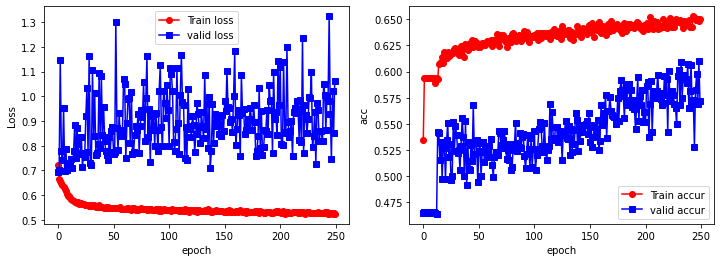

模型保存于2022-11-19_20_26_16


In [7]:
print(train_set)

# 当GPU可用时调用cuda
device = "cuda" if torch.cuda.is_available() else "cpu"

# 初始化模型并放在指定的设备上运行
model = Residual_Network().to(device)
model.device = device

# 对分类任务采用交叉熵损失
criterion = nn.CrossEntropyLoss()

# 初始化优化器（此处为Adam优化器，应用了自适应的学习率）
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


train_loss_epoch = []
train_acc_epoch = []
valid_loss_epoch = []
valid_acc_epoch = []

enter_ = 1
enter_2 = 1

best_acc = 0
stale = 0

for epoch in range(n_epochs):
    # ---------- Training ----------
    
    '''
    确保模型在训练集上处于训练模式
    '''
    model.train()
    

    '''
    记录训练结果
    '''
    train_loss = []
    train_accs = []

    '''
    迭代训练
    
    '''
    for batch in tqdm(train_loader):
        # 一个batch包含了图片和标签信息
        imgs, origin, labels = batch

        # 向前迭代
        logits = model(imgs.to(device), origin.to(device))
        
        
        # 计算交叉熵损失
        loss = criterion(logits, labels.to(device))

        optimizer.zero_grad()

        # 计算梯度
        loss.backward()

        # 防止梯度爆炸
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

        # 更新参数
        optimizer.step()

        # 计算当前批的准确率
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # 记录损失和准确率
        train_loss.append(loss.item())
        train_accs.append(acc.item())

    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)

    train_loss_epoch.append(train_loss)
    train_acc_epoch.append(train_acc)


    # 打印信息
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

    # ---------- 验证 ----------
    # 确保模型处于测试模式
    model.eval()

    # 用于记录信息
    valid_loss = []
    valid_accs = []

    # 迭代
    for batch in tqdm(valid_loader):
        imgs, origin, labels = batch

        # 迭代时不需要计算梯度
        with torch.no_grad():
            logits = model(imgs.to(device), origin.to(device))

        loss = criterion(logits, labels.to(device))

        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        valid_loss.append(loss.item())
        valid_accs.append(acc.item())

    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)

    valid_loss_epoch.append(valid_loss)
    valid_acc_epoch.append(valid_acc)

    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")

    _exp_name = "Residual_Network"
    # 更新日志
    if valid_acc > best_acc:
        with open(f"./{_exp_name}_log.txt", "a"):
            print(
                f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f} -> best")
    else:
        with open(f"./{_exp_name}_log.txt", "a"):
            print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")

    # 保存模型
    if valid_acc > best_acc:
        print(f"Best model found at epoch {epoch}, saving model")
        torch.save(model.state_dict(),
                   f"{_exp_name}_best.ckpt")
        best_acc = valid_acc
        stale = 0
    else:
        stale += 1
        if stale > patience:
            print(f"No improvement {patience} consecutive epochs, early stopping")
            break

'''
绘制训练损失和准确率曲线
'''
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(n_epochs), train_loss_epoch,
         "ro-", label="Train loss")
plt.plot(range(n_epochs), valid_loss_epoch,
         "bs-", label="valid loss")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.subplot(1, 2, 2)
plt.plot(range(n_epochs), train_acc_epoch,
         "ro-", label="Train accur")
plt.plot(range(n_epochs), valid_acc_epoch,
         "bs-", label="valid accur")
plt.xlabel("epoch")
plt.ylabel("acc")
plt.legend()
plt.show()

time_finish = time.strftime('%Y-%m-%d_%H_%M_%S', time.localtime())
print("模型保存于" + time_finish)